CIFAR10 dataset trained on all classes with 'normal' CNN without augmentation.

### Loading images
https://www.tensorflow.org/tutorials/load_data/images

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

import numpy as np
import os
import pathlib
import matplotlib.pyplot as plt

# Jupyter-specific
%matplotlib inline

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

MODEL = 'cnn' 
DS_INFO = 'complete'
NUM_EPOCHS = 50
BATCH_SIZE = 64

IMG_HEIGHT = 32
IMG_WIDTH = 32
NUM_CHANNELS = 3
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)

# epoch*batch_size*img_size
model_name = '{}x{}x{}_{}_{}'.format(NUM_EPOCHS, BATCH_SIZE, IMG_WIDTH, DS_INFO, MODEL)

Some parameters

In [21]:
data_dir = pathlib.Path('/mnt/sdb/cifar10/')
outcast = 'None'

DATASET_SIZE = len(list(data_dir.glob('*/*/*.*g')))

directories = np.array([item.name for item in data_dir.glob('train/*') if item.name != 'metadata.json'])

class_names = directories
NUM_CLASSES = len(directories)

train_size = int(0.7 * DATASET_SIZE)
val_size = int(0.15 * DATASET_SIZE)
test_size = int(0.15 * DATASET_SIZE)

In [33]:
%load_ext autoreload

In [45]:
%autoreload 2

In [46]:
import sys
sys.path.append('/home/henrik/master_thesis/code/utils')
from data_prep import create_dataset, print_class_info, show_image

In [47]:
NUM_CLASSES = 10
train_ds, test_ds, val_ds = create_dataset()

Class names:  ['cat' 'airplane' 'deer' 'automobile' 'ship' 'horse' 'truck' 'dog' 'bird'
 'frog']
cat               : 6000
airplane          : 6000
deer              : 6000
automobile        : 6000
ship              : 6000
horse             : 6000
truck             : 6000
dog               : 6000
bird              : 6000
frog              : 6000

Total number of images: 60000, in 10 classes


## Training
### Normal CNN
See https://www.tensorflow.org/tutorials/images/cnn

In [48]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

Create the model

In [49]:
cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=IMG_SIZE))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(BatchNormalization())

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dropout(0.2))
cnn_model.add(layers.Dense(NUM_CLASSES, activation='softmax'))

In [50]:
cnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)         

Compile and train the model

In [51]:
opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

cnn_model.compile(
                optimizer=opt,
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(MODEL), update_freq='batch')]

In [52]:
history = cnn_model.fit(
        train_ds,
        steps_per_epoch = train_size // BATCH_SIZE,
        epochs = NUM_EPOCHS,
        validation_data = test_ds,
        validation_steps = test_size // BATCH_SIZE,
        validation_freq = 1,
        callbacks = callbacks)

Train for 656 steps, validate for 140 steps
Epoch 1/50
656/656 [==============================] - 4s 7ms/step - loss: 1.5295 - accuracy: 0.4529 - val_loss: 1.3854 - val_accuracy: 0.5112
Epoch 2/50
656/656 [==============================] - 4s 5ms/step - loss: 1.1850 - accuracy: 0.5745 - val_loss: 1.2925 - val_accuracy: 0.5429
Epoch 3/50
656/656 [==============================] - 4s 5ms/step - loss: 1.0292 - accuracy: 0.6356 - val_loss: 0.9813 - val_accuracy: 0.6502
Epoch 4/50
656/656 [==============================] - 4s 5ms/step - loss: 0.9200 - accuracy: 0.6744 - val_loss: 0.9446 - val_accuracy: 0.6656
Epoch 5/50
656/656 [==============================] - 4s 6ms/step - loss: 0.8428 - accuracy: 0.7018 - val_loss: 0.7734 - val_accuracy: 0.7309
Epoch 6/50
656/656 [==============================] - 4s 6ms/step - loss: 0.7776 - accuracy: 0.7265 - val_loss: 0.7589 - val_accuracy: 0.7374
Epoch 7/50
656/656 [==============================] - 4s 6ms/step - loss: 0.7245 - accuracy: 0.7409 - va

KeyboardInterrupt: 

In [17]:
# cnn_model.save('models/{}.h5'.format(model_name))
# cnn_model = tf.keras.models.load_model('models/{}.h5'.format(model_name))

## Evaluate the model

In [23]:
cnn_evaluate = cnn_model.evaluate(val_ds, verbose=2, steps=val_size//BATCH_SIZE)

140/140 - 0s - loss: 0.5911 - accuracy: 0.8996


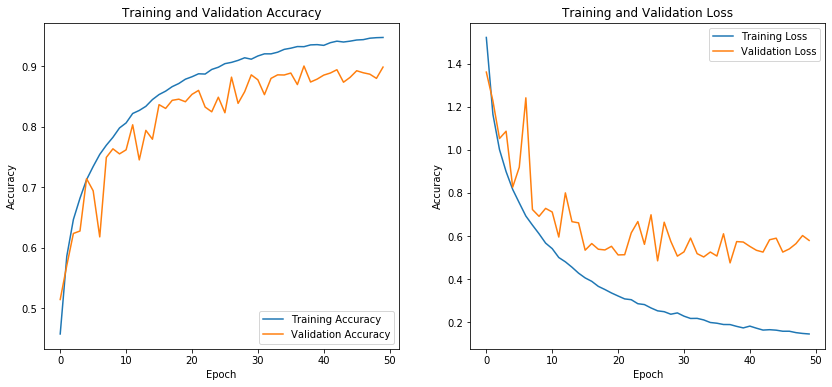

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(NUM_EPOCHS)

plt.figure(figsize=(14, 6))

# Subplot 1
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

# Subplot 2
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
# plt.ylim([0.5, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

`Tensorboard`

## Predict new samples

In [25]:
# Fetch one batch
images, labels = next(iter(val_ds))

# Convert from tensor to numpy array
images = images.numpy()
labels = labels.numpy()

0.0002 cat
0.0000 airplane
0.0000 deer
0.0000 automobile
0.0010 ship
0.0000 horse
0.0002 truck
0.0057 dog
0.9925 bird
0.0002 frog

Label: bird
Predicton: bird


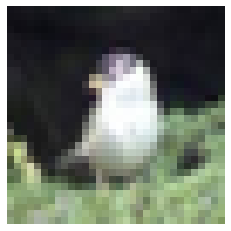

In [26]:
# Get a random image and label
rand = np.random.randint(0, BATCH_SIZE)
image = images[rand]
label = labels[rand]

# Predict one image
predictions = cnn_model.predict(np.expand_dims(image, axis=0))[0]

for i, pred in enumerate(predictions):
    print("{:0.4f} {}".format(pred,class_names[i]))

print ("\nLabel:", class_names[label])
print ("Predicton:", class_names[np.argmax(predictions)])

plt.figure(frameon=False, facecolor='white')
plt.imshow(image)
plt.axis('off');

In [27]:
# Predict one batch
predictions = cnn_model.predict(images)

print ('{:3}  {:10}  {:3}'.format('idx', 'label', 'pred'))
print ('---  -------     --------')

for i, pred in enumerate(predictions):
    label = class_names[labels[i]]
    prediction = class_names[np.argmax(pred)]
    print ('\n{:3}  {:10}  {:10}'.format(i, label, prediction), end='')
    if (label != prediction): print ("  Wrong", end='')

idx  label       pred
---  -------     --------

  0  frog        frog      
  1  automobile  automobile
  2  dog         dog       
  3  frog        horse       Wrong
  4  dog         dog       
  5  deer        deer      
  6  automobile  automobile
  7  bird        bird      
  8  automobile  automobile
  9  deer        deer      
 10  cat         cat       
 11  airplane    airplane  
 12  deer        deer      
 13  ship        ship      
 14  frog        frog      
 15  frog        frog      
 16  cat         dog         Wrong
 17  dog         dog       
 18  truck       truck     
 19  airplane    airplane  
 20  truck       truck     
 21  cat         cat       
 22  dog         dog       
 23  ship        ship      
 24  cat         cat       
 25  horse       horse     
 26  bird        bird      
 27  frog        frog      
 28  ship        ship      
 29  bird        bird      
 30  dog         cat         Wrong
 31  frog        frog      
 32  cat         cat       
 33  a